In [2]:
from polygon import RESTClient
from typing import cast
from urllib3 import HTTPResponse
import json
import pandas as pd
import datetime
import pytz
import talib
import ast
import uuid
import re
import os
import sys
from pathlib import Path
notebook_dir = Path().resolve()
project_root = notebook_dir.parents[0]
sys.path.insert(0, str(project_root))


API_KEY = "I0D0ldkssJgACZm3fcs9DlZAX5osmgZp"

from stockalerter.utils import grab_new_data_polygon
from indicators_lib import *
from indicators import extract_indicators

from utils import ops
from utils import supported_indicators
from utils import inverse_map
from utils import period_and_input

In [3]:
# DUMMY CONDITIONS
dummy_cond = "rsi(period=14, input=Close)[-1]>sma(period=50, input=Close)[-1]"
dummy_cond_breakout = "breakout(sma(period=30, input=Close)[-1] > sma(period = 50, input=Close)[-1])"

# DUMMY INDICATORS
dummy_ind_multi_input = "sma(period=30, input=rsi(period=30, input=Close))[-1]"
dummy_ind_crazy_recursive = "sma(period=30, input=rsi(period=30, input=sma(period=45, input = slope_sma(period=50, input=Close))))[-1]"
dummy_ind_macd = "macd(fast_period = 3, slow_period = 4, signal_period = 5, type = line, input = Close)[-1]"

cond_1 = "hma(period=20, input=Close)[-1] > ema(period=50, input=Close)[-1]"
cond_2 = "slope_hma(period=14, input=Close)[-1] > 0"
cond_3 = "roc(period=10, input=Close)[-1] > 5"
cond_4 = "atr(period=14, input=Close)[-1] > sma(period=14, input=Close)[-1] * 0.02"
cond_5 = "cci(period=20, input=Close)[-1] < -100"
cond_6 = "williamsr(period=14, input=Close)[-1] < -80"
cond_7 = "sar(acceleration=0.02, max_acceleration=0.2, input=Close)[-1] < Close[-1]"
cond_8 = "bbands(period=20, std_dev=2, type=upper, input=Close)[-1] < Close[-1]"
cond_9 = "breakout(rsi(period=14, input=hma(period=14, input=Close))[-1] > 70)"
cond_10 = "macd(fast_period=5, slow_period=10, signal_period=3, type=signal, input=Close)[-1] > macd(fast_period=5, slow_period=10, signal_period=3, type=line, input=Close)[-1]"
cond_11 = "sma(period=50, input=Close)[-1] >= sma(period=200, input=Close)[-1]"



In [4]:
aapl = grab_new_data_polygon("AAPL","day",5)

In [4]:
def extract_params(s):
    """
    extract_params("period=40,input=Close") turns into
    {'period': '40', 'input': 'Close'}
    """
    depth = 0
    parts = []
    start = 0
    for i,char in enumerate(s):
        if char == '(':
            depth+=1
        elif char == ')':
            depth-=1
        elif char == ',' and depth == 0:
            parts.append(s[start:i])
            start = i + 1
            
    parts.append(s[start:])

    return {k:v for k,v in [x.split("=",1) for x in parts]}


def is_number(s):
    """
    isnumeric() does not work for decimal or negative values, hence this is used
    """
    try:
        float(s)
        return True
    except ValueError:
        return False


# This function creates a saveable dict of indicators (nested)
# Contains all information to get one number out of it
# Debug mode turns on print statements

def ind_to_dict(ind, debug_mode = False):
    
    ind = ind.replace(" ","")

    # CHECKS FOR STANDALONE NUMBERS
    if is_number(ind):
        ind_dict = {"isNum" : True,
                    "number": int(ind),
                    "operable" : True,
                    "specifier" : -1}
        return ind_dict
    
    # CHECKS FOR OHLC
    if len(ind.split("(")) == 1:
        func = ind.split("[")[0]
        specifier = ind.split("[")[1].split("]")[0]
        return {'ind':func,
                'specifier':specifier,
                "operable":True}

    
    func = ind.split("(")[0]

    if debug_mode:
        print(f"Working on {func}")
    
    params = ind[(ind.find("(") + 1) : ind.rfind(")")]
    ind_dict =  extract_params(params)
    
    ind_dict['ind'] = func
    ind_dict['operable'] = True

    if "input" not in ind_dict:
        ind_dict["input"] = "Close"

    if len(ind.split("[")) > 1:
        ind_dict['specifier'] = ind.split("[")[1].split("]")[0]
    if ind_dict['input'].lower() not in ['open', 'high', 'low', 'close']:
        ind_dict['operable'] = False
        ind_dict['input'] = ind_to_dict(ind_dict['input'])

    return ind_dict

In [5]:
def simplify_conditions(cond, breakout_flag = False):
    """
    Trivial Case:
    convert rsi(period=14, input=Close)[-1]>sma(period=50, input=Close)[-1] to {cond1, cond2, comparison, breakoutflag=False}

    Breakout() Case:
    breakout(rsi(period=80, input=Close)[-1]<rsi(period=50, input=Close)[-1]) to {cond1, cond2, comparison, breakoutflag=True}
    """
    cond = cond.replace(" ", "")  # Remove spaces
    operators = sorted(list(inverse_map.keys()), key=len, reverse=True)  # Sort by length (longest first)

    # If the condition starts with "breakout"
    if cond[0:8] == "breakout":
        return simplify_conditions(cond[9:-1], True)

    # For multi-character and single-character operators
    for operator in operators:
        if operator in cond:
            # Split the condition by the operator
            ind1, ind2 = cond.split(operator, 1)  # Split only once
            return {
                'ind1': ind_to_dict(ind1),
                'ind2': ind_to_dict(ind2),
                'comparison': operator,
                'breakout_flag': breakout_flag
            }


In [12]:
simplify_conditions("sma(period=50, input=Close)[-1] >= sma(period=200, input=Close)[-1]")

{'ind1': {'period': '50',
  'input': 'Close',
  'ind': 'sma',
  'operable': True,
  'specifier': '-1'},
 'ind2': {'period': '200',
  'input': 'Close',
  'ind': 'sma',
  'operable': True,
  'specifier': '-1'},
 'comparison': '>=',
 'breakout_flag': False}

In [89]:
def apply_function(df, ind, vals= None, debug_mode = False):
    # If it is a flat number, simply return it
    if 'isNum' in ind and ind['isNum']:
        return ind['number']

    func = ind['ind']

    if debug_mode:
        print(f'At position 1, and func is {func}')

    if func in ["Close", "Open", "High", "Low"]:
        calculated = df[func]
    
    # INPUT FRIENDLY
    elif func in period_and_input:
        if vals is None:
            calculated = supported_indicators[func](df, int(ind['period']), ind['input'])
        else:
            calculated = supported_indicators[func](df, int(ind['period']), vals)
        
    elif func in ['macd','bbands']:
        if vals is None:
            if func == "macd":
                calculated = MACD(df,int(ind['fast_period']),int(ind['slow_period']),int(ind['signal_period']), ind['type'], ind['input'])
            else:
                calculated = BBANDS(df,int(ind['period']),float(ind['std_dev']),ind['type'], ind['input'])
        else:
            if func == "macd":
                calculated = MACD(df,int(ind['fast_period']),int(ind['slow_period']),int(ind['signal_period']), ind['type'], vals)
            else:
                calculated = BBANDS(df,int(ind['period']),float(ind['std_dev']),ind['type'], vals)

    # CHECK TO SEE IF INPUT UNFRIENDLY RECIEVED INPUT
    elif ind['input'] not in ['Close', 'Open', 'High', 'Low']:
        raise ValueError("You entered input with a forbidden value")
    
    # INPUT UNFRIENDLY
    elif func in ['atr', 'cci', 'williamsr']:
        calculated = supported_indicators[func](df, int(ind['period']))    

    elif func == "sar":
        calculated = SAR(df, float(ind['acceleration']), float(ind['max_acceleration']))


    if 'specifier' in ind:
        return calculated.iloc[int(ind['specifier'])]
    
        # DEPRECATED VERSION BUT WORKS
        #return calculated[int(ind['specifier'])]

    return calculated

In [90]:
def indicator_calculation(df, ind_dict, values = None, debug_mode = False):
    if debug_mode:
        print(f"at {ind_dict['ind']} and values are {values}, and it is {ind_dict['operable']}")

    if not ind_dict['operable'] and values is None: #Skips to deepest layer
        if debug_mode:
            print(f"Going from {ind_dict['ind']} to {ind_dict['input']}")
        
        values = indicator_calculation(df, ind_dict['input'], None, debug_mode)

        if debug_mode:
            print(f"\nback from  {ind_dict['input']}, values are {values}")
            print(ind_dict)

    if ind_dict['operable']: #Only triggers at deepest layer
        if debug_mode:
            print(f"\nreached {ind_dict['input']}")
            print(ind_dict)
        values = (apply_function(df, ind_dict))
        if debug_mode:
            print(f"\nreached {ind_dict['input']}")
            print(ind_dict)
        return values
    
    if debug_mode:
        print(f"At {ind_dict['ind']} and values are {len(values)}")
    
    if values is not None: # FOR ALL OTHER LAYERS
        if debug_mode:
            print(f"At {ind_dict['ind']}")
        values = (apply_function(df, ind_dict, values))
        return values

In [91]:
# Function to take a full expression and evaluate the result (Boolean result)
def evaluate_expression(df, exp, debug_mode=False):
    exp = simplify_conditions(exp)
    lhs = indicator_calculation(df, exp['ind1'])
    rhs = indicator_calculation(df, exp['ind2'])

    if debug_mode and not exp['breakout_flag']:
        print(f"LHS is {lhs} \nRHS is {rhs}")

    op = exp['comparison']
    if not exp['breakout_flag']:
        return bool(ops[op](lhs,rhs))
    
    # if breakout is there, we need to calculate yesterdays lhs and rhs too
    exp['ind1']['specifier'] = str(int(exp['ind1']['specifier'])-1)
    exp['ind2']['specifier'] = str(int(exp['ind2']['specifier'])-1)

    lhs_yest = indicator_calculation(df, exp['ind1'])
    rhs_yest = indicator_calculation(df, exp['ind2'])

    if debug_mode:
        print(f"LHS is {lhs} \nRHS is {rhs} \nLHS_yest is {lhs_yest} \nRHS_yest is {rhs_yest}\nExpression: {lhs}{op}{rhs}")

    return bool(ops[op](lhs,rhs) and ops[inverse_map(op)](lhs_yest,rhs_yest))

In [92]:
def validate_referenced_indices(expr, bools):
    import re
    referenced = set(int(num) for num in re.findall(r'\b\d+\b', expr))
    for idx in referenced:
        if not 1 <= idx <= len(bools):
            raise ValueError(f"Invalid reference: {idx} is out of range (1 to {len(bools)})")
    return referenced

In [93]:
#indicator_calculation(aapl,ind_to_dict("sma(period=30,input=rsi(period = 30, input = Close))[-1]"))
evaluate_expression(aapl,"sma(period=30,input=rsi(period = 30, input = Close))[-1]<0", debug_mode=True)

LHS is 42.14113800939959 
RHS is 0


False

In [94]:
def evaluate_boolean_expression(expr, bools):
    # Find all standalone numbers in the expression
    referenced = set(int(num) for num in re.findall(r'\b\d+\b', expr))

    # Replace each number with a variable like var_1, var_2, etc.
    for i in sorted(referenced, reverse=True):  # biggest to smallest to avoid partials
        expr = re.sub(rf'\b{i}\b', f'var_{i}', expr)

    context = {f'var_{i+1}': val for i, val in enumerate(bools)}
    
    return eval(expr, {}, context)


In [95]:
def evaluate_expression_list(df, exps, combination = '1'):
    """
    Wrapper on whole backend
    \nAccepts a list of expressions and combination logic, outputs a boolean value
    """
    bools = []
    for exp in exps:
        bools.append(evaluate_expression(df, exp))

    evaluate_boolean_expression(combination,bools)

In [96]:
# Test block
# LEFT TO TEST: RAISING ERRORS FOR INPUT WITH A FORBIDDEN FUNCTION
# LEFT TO TEST: validate_referenced_indices
# LEFT TO TEST: Recursive indicator calculation

#test = dummy_cond_breakout
test = cond_6
print(f'Test input is {test}')
print()

#evaluate_expression(aapl, test, debug_mode=True)
#(simplify_conditions(test)['ind1'])
#indicator_calculation(aapl,simplify_conditions(test)['ind1'])
apply_function(aapl, simplify_conditions(test)['ind1'])


Test input is williamsr(period=14, input=Close)[-1] < -80



np.float64(-48.69712585911339)

In [98]:
# TEST BBANDS AND MACD INDICATOR CALCULATION
indicator_calculation(aapl,ind_to_dict("bbands(period=30,std_dev=3,type=middle,input=sma(period=30))[-1]"))

TypeError: BBANDS() takes 4 positional arguments but 5 were given

In [99]:
# COND 9 EXTENSIVE TEST
aapl['hma_14'] = HMA(aapl, 14, 'Close')
aapl['rsi_on_hma'] = RSI(aapl, 14, aapl["hma_14"])

aapl['rsi_on_hma'][-1]


test = cond_9
print(f'Test input is {simplify_conditions(test)['ind1']}')
print()

indicator_calculation(aapl,simplify_conditions(test)['ind1'], debug_mode=True)

Test input is {'period': '14', 'input': {'period': '14', 'input': 'Close', 'ind': 'hma', 'operable': True}, 'ind': 'rsi', 'operable': False, 'specifier': '-1'}

at rsi and values are None, and it is False
Going from rsi to {'period': '14', 'input': 'Close', 'ind': 'hma', 'operable': True}
at hma and values are None, and it is True

reached Close
{'period': '14', 'input': 'Close', 'ind': 'hma', 'operable': True}

reached Close
{'period': '14', 'input': 'Close', 'ind': 'hma', 'operable': True}

back from  {'period': '14', 'input': 'Close', 'ind': 'hma', 'operable': True}, values are Date
12-04-2024 00:00:00 EDT           NaN
15-04-2024 00:00:00 EDT           NaN
16-04-2024 00:00:00 EDT           NaN
17-04-2024 00:00:00 EDT           NaN
18-04-2024 00:00:00 EDT           NaN
                              ...    
07-04-2025 00:00:00 EDT    200.914230
08-04-2025 00:00:00 EDT    188.748881
09-04-2025 00:00:00 EDT    182.585754
10-04-2025 00:00:00 EDT    179.715817
11-04-2025 00:00:00 EDT    

/var/folders/b7/hmbpghys7mq6k7fycktb9qpw0000gn/T/ipykernel_98026/1396429954.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aapl['rsi_on_hma'][-1]


np.float64(17.769951166761754)

                          Close   kalman_20
Date                                       
13-06-2025 00:00:00 EDT  196.45  198.610730
16-06-2025 00:00:00 EDT  198.42  198.531026
17-06-2025 00:00:00 EDT  195.64  197.322893
18-06-2025 00:00:00 EDT  196.58  197.012445
20-06-2025 00:00:00 EDT  201.00  198.678807


/Users/akeenkarkare/stockalerter/venv/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/Users/akeenkarkare/stockalerter/venv/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


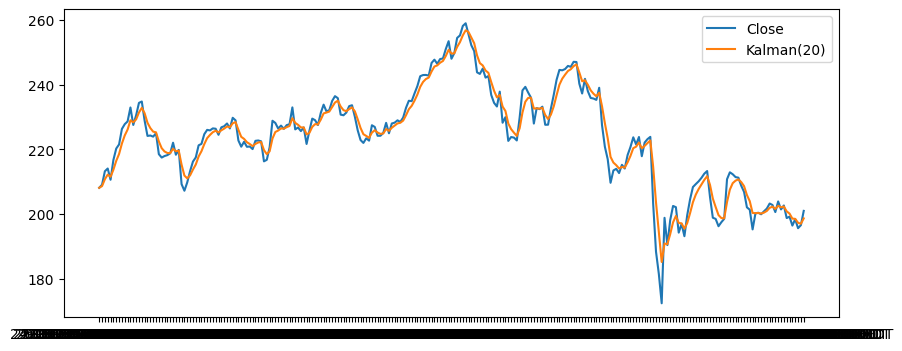

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

aapl_poly = grab_new_data_polygon("AAPL", "day", 30)

df = aapl_poly.copy()
from indicators_lib import KALMAN
df["kalman_20"] = KALMAN(df, period=30, input="Close")

print(df[["Close", "kalman_20"]].tail(5))

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Close"],    label="Close")
plt.plot(df.index, df["kalman_20"], label="Kalman(20)")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Pick one:
df = grab_new_data_polygon("AAPL", "day", 60)
# df = grab_new_data_yfinance("AAPL", "day", 60)

# 2) Import your indicators
from indicators_lib import *

# 3) Compute each series
df["kal_col"]   = KALMAN_COLOURS(df, period=20, input="Close")
df["kal_trans"] = KALMAN_COLOUR_TRANSITIONS(df, period=20, input="Close")

df["st_trend"]  = SUPER_TREND(df, atr_period=10, multiplier=3)
df["st_col"]    = SUPER_TREND_COLOURS(df, atr_period=10, multiplier=3)
df["st_trans"]  = SUPER_TREND_COLOUR_TRANSITIONS(df, atr_period=10, multiplier=3)


# 4) Inspect samples
print("\n=== Kalman colours & transitions (last 10) ===")
print(df[["Close","kal_col","kal_trans"]].tail(10))

print("\n=== Supertrend (+1/–1), colours & transitions (last 10) ===")
print(df[["Close","st_trend","st_col","st_trans"]].tail(10))

# 5) Quick visual check
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)

ax[0].plot(df.index, df["Close"],   label="Close")
ax[0].scatter(df.index, df["Close"],
              c=df["kal_col"].map({"green":"g","red":"r"}),
              s=8, label="Kalman colour")
ax[0].set_title("Close with Kalman colour")

ax[1].plot(df.index, df["st_trend"], label="Supertrend")
ax[1].scatter(df.index, df["st_trend"],
              c=df["st_col"].map({"green":"g","red":"r"}),
              s=8, label="ST colour")
ax[1].set_title("Supertrend trend & colour")

for a in ax:
    a.legend()
plt.tight_layout()
plt.show()


KeyError: '2025-06-06'